In [4]:
%load_ext autoreload
%autoreload 2
import sys
path = "/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt

In [5]:
events = np.loadtxt(path + "data/slider-depth/processed/events_corner_filt_ref.txt")

In [6]:
time_range = [1.4, 1.5]
idx_range = [np.searchsorted(events[:,0], time_range[0]), np.searchsorted(events[:,0], time_range[1])]
events_time = events[idx_range[0]:idx_range[1], :]

In [7]:
img_shape = (180, 240)
window_size = (9, 9)
d = int(window_size[0] / 2)

In [8]:
id_img = np.zeros(img_shape)
id_count = 1
events_id = []
t = 0
for e in events_time:
    x = int(e[1])
    y = int(e[2])
    
    if e[3] == 1:
        continue
    
    if x >= img_shape[1] - d or x <= d:
        continue
    if y >= img_shape[0] - d or y <= d:
        continue
    wind = id_img[y-d : y+d+1, x-d : x+d+1]
    
    #new id
    if not wind.any():
        id_img[y, x] = id_count
        
        events_id.append([e[0], x, y, e[3], id_count])
        
        id_count += 1
        continue
    
    #only one id in wind
    if len(wind[wind != 0]) == 1:
        idx = wind[wind != 0][0]
        events_id.append([e[0], x, y, e[3], idx])
        id_img[y-d : y+d+1, x-d : x+d+1] = np.zeros(window_size)
        id_img[y, x] = int(idx)
    else:
#         idx = wind[wind != 0][0]#pick one
#         events_id.append([e[0], x, y, e[3], idx])
#         id_img[y-d : y+d+1, x-d : x+d+1] = np.zeros(window_size)
#         id_img[y, x] = idx
        t += 1

In [9]:
len(events_id)

783

In [10]:
id_count

189

In [11]:
t

155

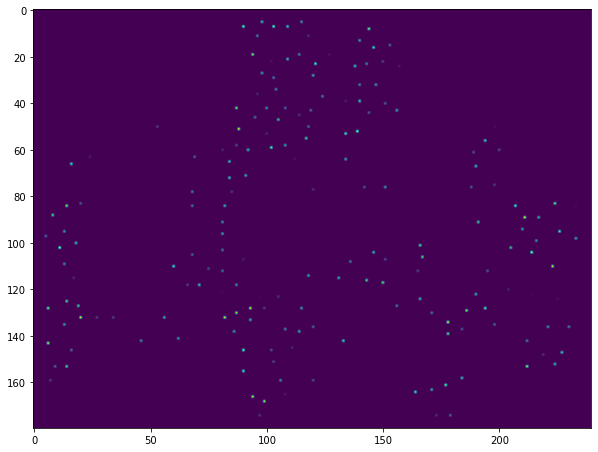

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(id_img)

In [13]:
img = np.zeros(img_shape)
for e in events_id:
    x = int(e[1])
    y = int(e[2])
    
    img[y, x] = e[4]

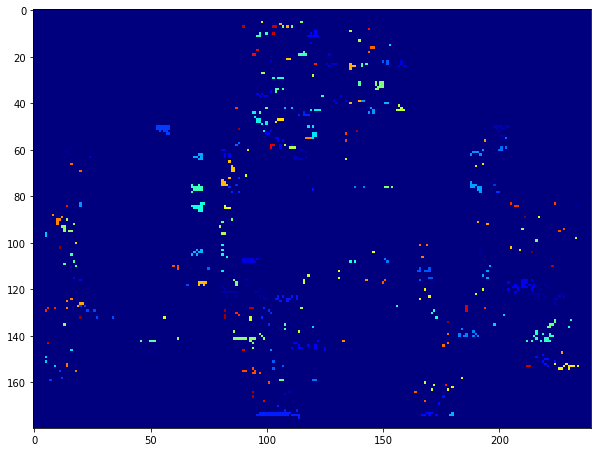

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="jet", interpolation="none")

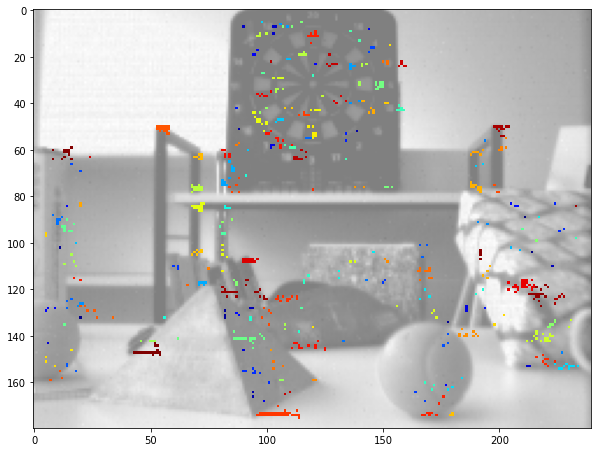

In [16]:
img_grey = plt.imread(path + "data/slider-depth/images/frame_00000039.png")

time_diff_m = np.ma.masked_where(img <= 0, img)

plt.figure(figsize=(10, 10))
plt.imshow(img_grey, cmap="gray", alpha=0.5)
m = plt.imshow(time_diff_m, interpolation="none", cmap="jet_r")
#plt.colorbar(mappable=m)

In [17]:
corner_dict = {}
for e in events_id:
    idx = e[4]
    if idx in corner_dict:
        corner_dict[idx].append(e)
    else:
        corner_dict[idx] = [e]

In [30]:
img = np.zeros(img_shape)
for k in corner_dict:
    if len(corner_dict[k]) <= 2:
        continue
    vels = []
    last_e = corner_dict[k][0]
    for e in corner_dict[k][1:]:
        x_dis = e[1] - last_e[1]
        y_dis = e[2] - last_e[2]
        dis = np.sqrt(x_dis**2 + y_dis**2)
        t_diff = e[0] - last_e[0]
        if dis == 0 or t_diff == 0:
            continue
        vel = dis / t_diff
        vels.append(vel)
        last_e = e
        
    vel_med = np.median(np.array(vels))
#     if vel_med > 100:
#         continue
    x = int(last_e[1])
    y = int(last_e[2])
    img[y, x] = vel_med

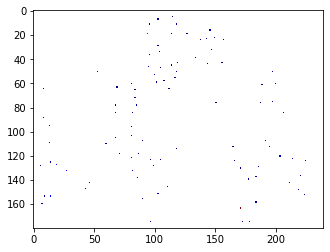

In [31]:
img_m = np.ma.masked_where(img <=0, img)
plt.imshow(img_m, cmap="jet", interpolation="none")

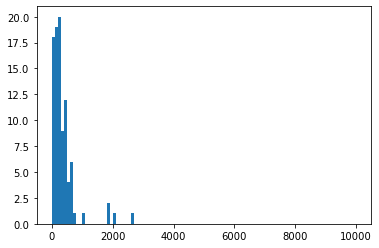

In [32]:
plt.hist(img.flatten(), 100, range=(0.1, 10000));

In [21]:
#np.savetxt("events_corner_id.txt", events_id)

In [36]:
img = np.zeros(img_shape)
for k in corner_dict:
    if len(corner_dict[k]) <= 2:
        continue
    e = corner_dict[k][-1]
    last_e = corner_dict[k][0]
    x_dis = e[1] - last_e[1]
    y_dis = e[2] - last_e[2]
    dis = np.sqrt(x_dis**2 + y_dis**2)
    t_diff = e[0] - last_e[0]
    if dis == 0 or t_diff == 0:
        continue
    vel = dis / t_diff
#     if vel_med > 100:
#         continue
    x = int(e[1])
    y = int(e[2])
    img[y, x] = vel

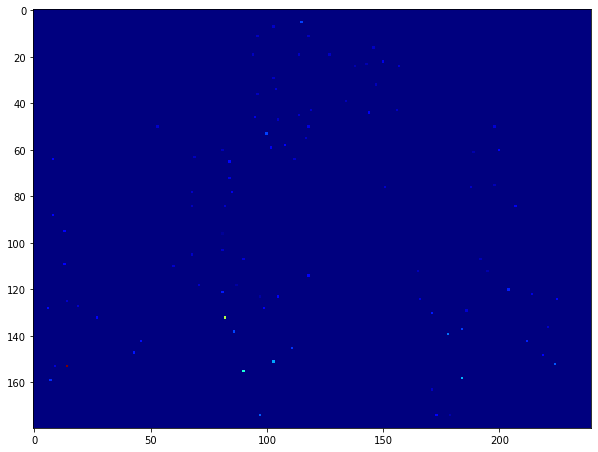

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="jet", interpolation="none")

In [367]:
plt.hist(img.flatten(), 100, range=(0.01, 300));

In [368]:
time_diff_med_m = np.ma.masked_where(img<=0, img)
u = time_diff_med_m

v = 0.2901460156636141
f = 335.419462958

d = np.divide(f, u, where=u>0.0) * v

plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r", vmin=0, interpolation="none")
#plt.colorbar(m)

In [369]:
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if d.mask[y, x] or d.data[y, x] > 30:
            continue
        points.append([x, y, d.data[y, x]])
points = np.array(points)

In [370]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [371]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2], cmap="jet_r", vmin=0, vmax=3)
set_axes_equal(ax)
ax.set_zlim3d([0, 3])
plt.show()